In [45]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Data path is assumed to be 'data' under repo root
def csv_loader(filename, datapath = "./data"):
    print('Loading %s.' % filename)
    path = os.path.join(datapath, filename)
    try:
        with open(path, 'rb') as f:
              data = pd.read_csv(f)
    except Exception as e:
        print('Unable to load data ', path, ':', e)
    return data

# Data

In [4]:
df_train = csv_loader("application_train.csv")
df_train.head(3)

Loading application_train.csv.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
col_categorical = [col for col in df_train.columns if df_train[col].dtype == 'object']

print("{:d} data, {:d} columns, {:d} catagorical".format(len(df_train), len(df_train.columns), len(col_categorical)))

307511 data, 122 columns, 16 catagorical


In [21]:
for col in df_train.columns:
    print("{:40s}".format(col), df_train[col].dtype)

SK_ID_CURR                               int64
TARGET                                   int64
NAME_CONTRACT_TYPE                       object
CODE_GENDER                              object
FLAG_OWN_CAR                             object
FLAG_OWN_REALTY                          object
CNT_CHILDREN                             int64
AMT_INCOME_TOTAL                         float64
AMT_CREDIT                               float64
AMT_ANNUITY                              float64
AMT_GOODS_PRICE                          float64
NAME_TYPE_SUITE                          object
NAME_INCOME_TYPE                         object
NAME_EDUCATION_TYPE                      object
NAME_FAMILY_STATUS                       object
NAME_HOUSING_TYPE                        object
REGION_POPULATION_RELATIVE               float64
DAYS_BIRTH                               int64
DAYS_EMPLOYED                            int64
DAYS_REGISTRATION                        float64
DAYS_ID_PUBLISH                        

In [31]:
col_int = [col for col in df_train.columns if df_train[col].dtype == 'int64']
df_train[col_int].isnull().sum(axis=0)

SK_ID_CURR                     0
TARGET                         0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUMENT_9                0
FLAG_DOCUMENT_10               0
FLAG_DOCUM

In [32]:
df_train[col_int].describe(include="all")

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
col_num = [col for col in df_train.columns if df_train[col].dtype == 'float64']
df_train[col_num].isnull().sum(axis=0)

AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
REGION_POPULATION_RELATIVE           0
DAYS_REGISTRATION                    0
OWN_CAR_AGE                     202929
CNT_FAM_MEMBERS                      2
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE          

In [33]:
df_train[col_num].describe(include="all")

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,5.000000,2.000000,0.334007,3.924574e-01,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,9.000000,2.000000,0.505998,5.659614e-01,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,15.000000,3.000000,0.675053,6.636171e-01,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,91.000000,20.000000,0.962693,8.549997e-01,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [24]:
df_train[col_categorical].isnull().sum(axis=0)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [34]:
df_train[col_categorical].describe(include="all")

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


# Model

In [44]:
all_categorical_feats = list(set(col_categorical + [col for col in df_train.columns if col[:4] == "FLAG"]))
all_categorical_feats

['FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_12',
 'FLAG_WORK_PHONE',
 'HOUSETYPE_MODE',
 'NAME_EDUCATION_TYPE',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_18',
 'FLAG_OWN_REALTY',
 'FLAG_DOCUMENT_4',
 'FLAG_PHONE',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_9',
 'NAME_CONTRACT_TYPE',
 'FLAG_DOCUMENT_15',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'FLAG_DOCUMENT_11',
 'NAME_HOUSING_TYPE',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_19',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_14',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_20',
 'CODE_GENDER',
 'FLAG_DOCUMENT_16',
 'ORGANIZATION_TYPE',
 'FLAG_EMAIL',
 'FONDKAPREMONT_MODE',
 'NAME_INCOME_TYPE',
 'EMERGENCYSTATE_MODE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_13',
 'WALLSMATERIAL_MODE',
 'FLAG_CONT_MOBILE',
 'NAME_FAMILY_STATUS']

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

for col in all_categorical_feats:
    df_train[col] = df_train[col].astype('category') 
X = df_train.drop('TARGET', axis=1) 
Y = df_train['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123, stratify=Y)

In [ ]:
# todo: normalization

In [53]:
estimator = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', silent=False)
param_grid = {
    'n_estimators': [200],
    'max_depth':[5],
    'max_delta_step':[0,2],
    'learning_rate': [0.1,0.2,0.3] 
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
gbm = GridSearchCV(estimator, param_grid,  cv=kfold,  verbose=100, scoring=['f1','roc_auc'], refit='roc_auc')
grid_result = gbm.fit(X_train, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.270575578267886, roc_auc=0.7504852060821952, total=  19.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27792797664107277, roc_auc=0.7571476735557036, total=  18.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.8s remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27387715725158107, roc_auc=0.7576641119719532, total=  18.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2750482729028106, roc_auc=0.7538804876079093, total=  18.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27197098976109213, roc_auc=0.753030883655575, total=  19.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.26962659626057434, roc_auc=0.7498657026334463, total=  22.9s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27711300016243434, roc_auc=0.7566930541203859, total=  21.2s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.3min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2773722627737226, roc_auc=0.7588141865933522, total=  20.8s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27352545111769455, roc_auc=0.7540984118482922, total=  20.1s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2722939317658401, roc_auc=0.7530609700034492, total=  19.9s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.7min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.26902939991945224, roc_auc=0.7400589445597404, total=  20.3s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  5.2min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27958097200755627, roc_auc=0.7491410468014104, total=  18.8s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.6min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27483856349835734, roc_auc=0.7499878933654307, total=  17.4s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  6.0min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2749310661764706, roc_auc=0.7442712142484846, total=  16.2s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  6.4min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2754689014309332, roc_auc=0.7489034987377762, total=  18.2s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.9min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27002679742288616, roc_auc=0.7423874873395218, total=  17.9s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  7.3min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27938922631549074, roc_auc=0.7512057094777304, total=  17.7s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  7.7min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2776332164271976, roc_auc=0.7517601265457806, total=  16.9s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  8.1min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27619645199931553, roc_auc=0.7468251193540171, total=  18.7s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  8.6min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2744183400648501, roc_auc=0.7438350651825597, total=  20.5s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.1min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2700173933905116, roc_auc=0.7327157892111906, total=  18.1s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  9.5min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27706510010790075, roc_auc=0.7382133924871848, total=  17.4s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  9.9min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2735580346546404, roc_auc=0.7379482989371322, total=  19.1s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 10.4min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.26991733556966574, roc_auc=0.7364086802136167, total=  18.3s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 10.9min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2682518819452742, roc_auc=0.7333964272715171, total=  19.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 11.3min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2683380315480118, roc_auc=0.7329023260101275, total=  19.6s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 11.8min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.277624475104979, roc_auc=0.7400486580950579, total=  21.6s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 12.3min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27099396330165565, roc_auc=0.7369058369898153, total=  18.8s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 12.7min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27099168112992994, roc_auc=0.7343569805459281, total=  21.4s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 13.2min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.273806696746616, roc_auc=0.7348560187068172, total=  21.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.7min finished


# Evaluation

Best: 0.754506 using {'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
0.754442 (0.002671) with: {'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.754506 (0.003070) with: {'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
0.746473 (0.003778) with: {'learning_rate': 0.2, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.747203 (0.003781) with: {'learning_rate': 0.2, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
0.735737 (0.002284) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.735814 (0.002476) with: {'learning_rate': 0.3, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}


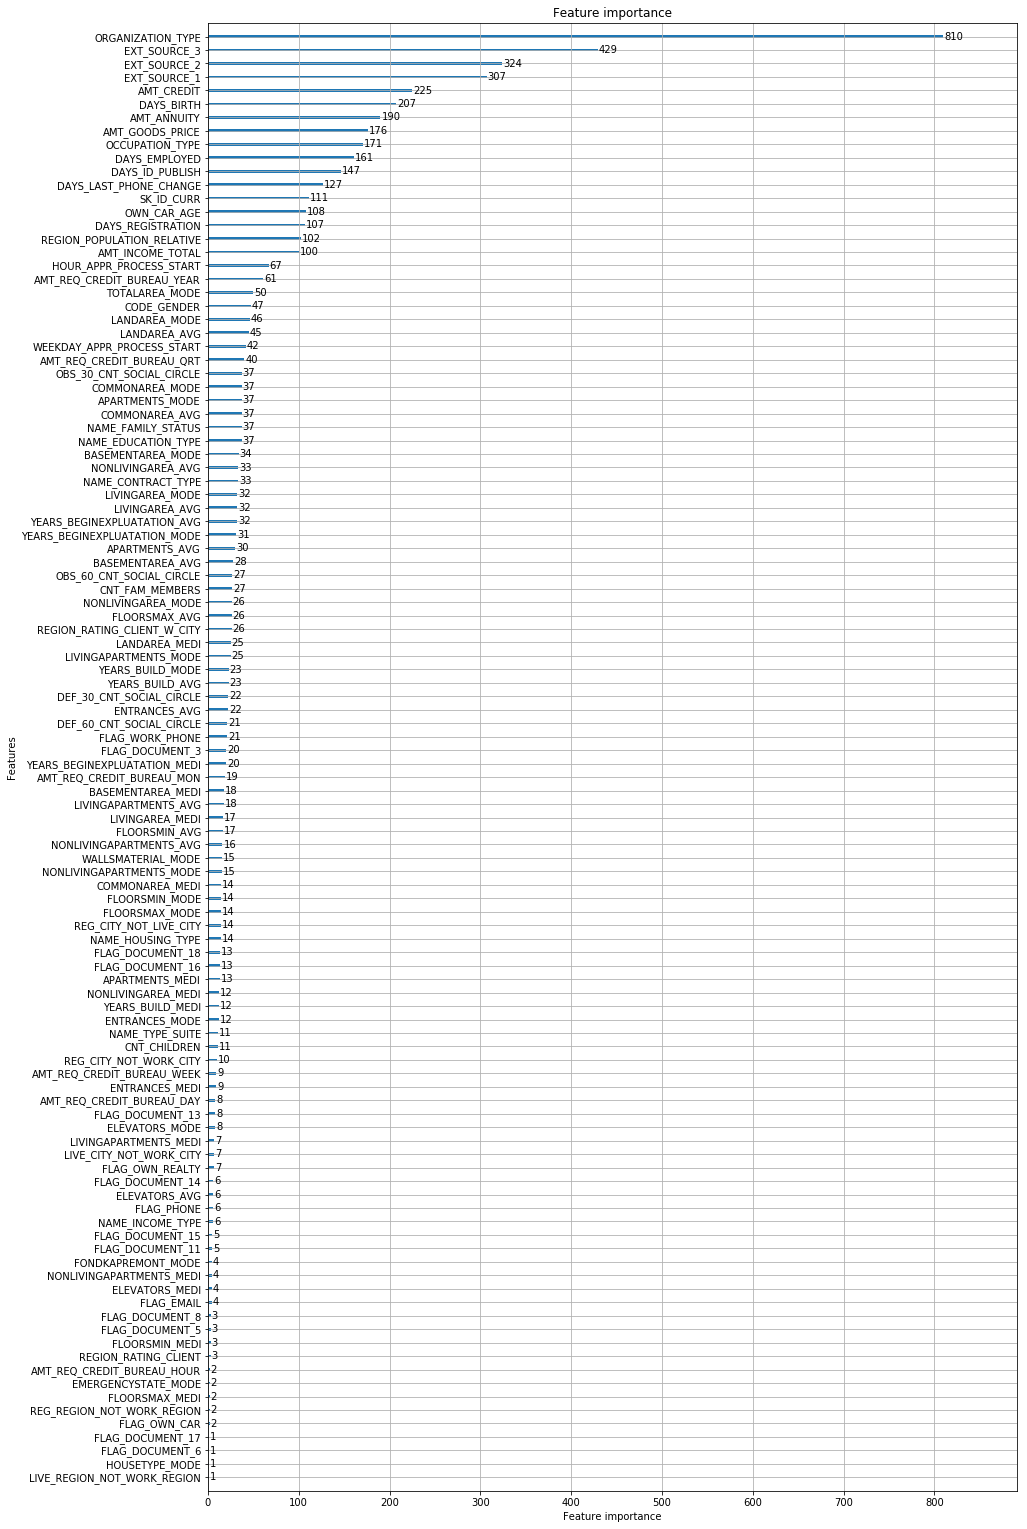

In [59]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_roc_auc']
stds = grid_result.cv_results_['std_test_roc_auc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

lgb.plot_importance(grid_result.best_estimator_)
plt.gcf().set_size_inches(14.5, 27)

c:\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion Matrix:


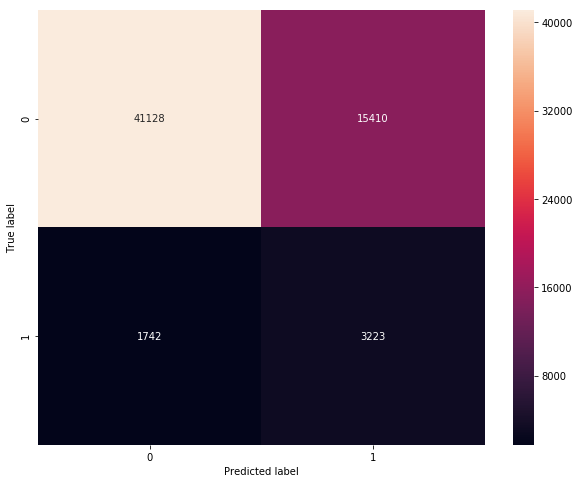

In [65]:
import seaborn as sns

Y_pred = grid_result.predict(X_test)

print('Confusion Matrix:')

df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred))
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt="d", ax=ax)
ax.set_ylabel('True label');
ax.set_xlabel('Predicted label');

In [67]:
prob_xgb = pd.DataFrame(list(grid_result.predict_proba(X_test)))
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_test, prob_xgb.iloc[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
p_xgb,r_xgb,thre_xgb = precision_recall_curve(Y_test,prob_xgb.iloc[:,1])
average_p_xgb = average_precision_score(Y_test, prob_xgb.iloc[:,1])

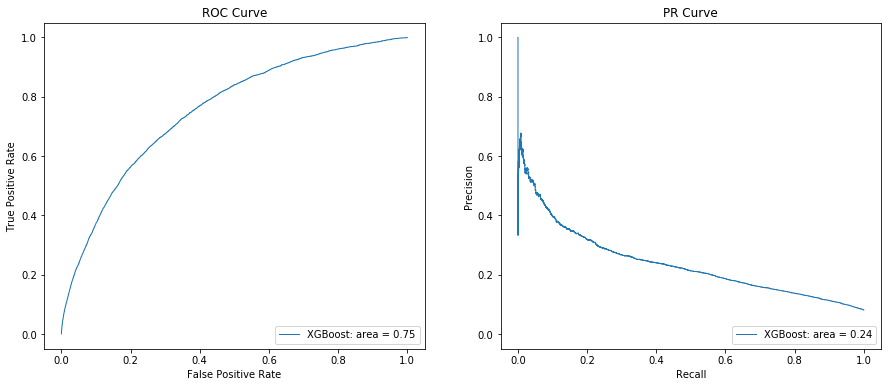

In [68]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curve')

ax1.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost: area = %0.2f'%roc_auc_xgb)

ax2.plot(r_xgb, p_xgb, lw=1, label='XGBoost: area = %0.2f'%average_p_xgb)

ax1.legend(loc='lower right')    
ax2.legend(loc='lower right')

plt.show()

In [70]:
# calculate accuracy for xgboost
score_xgb = grid_result.score(X_test, Y_test)

In [71]:
score_lr = 0
roc_auc_lr = 0
average_p_lr = 0

result = {'Model':['XGBoost'],
          'Binary Accuracy':[score_xgb],
          'AUC of ROC':[roc_auc_xgb],
          'AUC of PR':[average_p_xgb]}
pd.DataFrame(result,columns=['Model', 'Binary Accuracy', 'AUC of ROC', 'AUC of PR'])

,Model,Binary Accuracy,AUC of ROC,AUC of PR
0,XGBoost,0.754267,0.754267,0.237291


# Kaggle

In [73]:
df_test = csv_loader("application_test.csv")
df_test.head(3)

Loading application_test.csv.


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [74]:
for col in all_categorical_feats:
    df_test[col] = df_test[col].astype('category') 

In [82]:
# Refit
best_param = {'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
est = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', silent=False, **best_param)

In [83]:
final_model = est.fit(X, Y)
prediction = pd.DataFrame(list(final_model.predict_proba(df_test)))

In [98]:
df_test["TARGET"] = prediction.iloc[:,1]
df_test[["SK_ID_CURR","TARGET"]].to_csv("./results/lgb_model_1st.csv", index = False)